# Regression analysis with SQL 
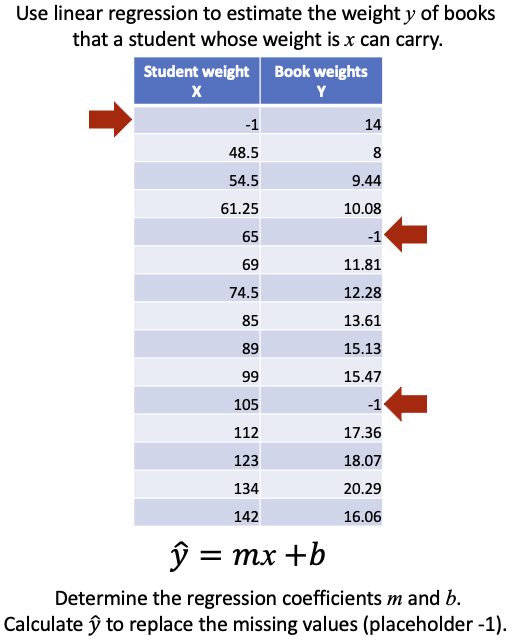

In [ ]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from DATA225utils import make_connection, dataframe_query

%matplotlib inline

In [ ]:
conn = make_connection(config_file = 'StudentBooks.ini')
cursor = conn.cursor()

In [ ]:
cursor.execute('DROP TABLE IF EXISTS weights')

sql = """
    CREATE TABLE weights
    (
        student DOUBLE NOT NULL,
        books   DOUBLE NOT NULL,
        PRIMARY KEY(student, books)
    )
    """

cursor.execute(sql)

## Student and textbook weights with missing weights
#### -1 is the placeholder for missing weights.

In [ ]:
student_weights  = [48.50, 54.50, 61.25, 65.00, 69.00, 74.50, 85.00,    -1, 89.00, 99.00, 105.00, 112.00, 123.00, 134.00, 142.00]
textbook_weights = [ 8.00,  9.44, 10.08,    -1, 11.81, 12.28, 13.61, 14.00, 15.13, 15.47,     -1, 17.36,  18.07,  20.29,  16.06 ]

values = list(zip(student_weights, textbook_weights))
values

## Load the `weights` table

In [ ]:
sql = ( """
        INSERT INTO weights
        VALUES (%s, %s)
        """
      )

cursor.executemany(sql, values)
conn.commit()

## Function to display the `weights` table and return its rows

In [ ]:
def display_and_return(cursor):
    """
    Query the weights table, print its rows as a dataframe,
    and return the rows as a numpy array.
    """
    _, df = dataframe_query(conn, """
        SELECT student AS student_weights,
               books AS book_weights
        FROM weights
        """
                           )
    
    display(df)
    return df.to_numpy()

## The dirty `weights` table
#### -1 is the placeholder for missing weights.

In [ ]:
rows = display_and_return(cursor)

In [ ]:
def draw_graph(max_x, m, b):
    """
    Draw a linear regression trend line with slope m
    and y intercept b from x = 0 to max_x.
    """
    # The regression line. We only need the end points.
    # End point 1: (0, b)
    # End point 2: (max_x, m*max_x + b)
    plt.plot([0, max_x], [b, max_x + b], color='red')

## Function to execute multiple SQL statements

In [ ]:
def execute_multiple_SQL(cursor, sql, trace=False):
    """
    Use the cursor to execute multiple SQL statements.
    Print an execution trace if trace=True.
    """
    for crsr in cursor.execute(sql, multi=True):
        if crsr.with_rows:
            results = crsr.fetchall()
            if trace:
                print(crsr.statement)
                print('  ==> ', results)
        else:
            if trace:
                print(crsr.statement)
                if crsr.rowcount > 0:
                    print(f'  ==> {crsr.rowcount} row(s) affected.')

## SQL to clean the data

#### In `SELECT` we must use the assignment operator `:=` because `=` is the equality operator.

In [ ]:
sql = ( 
    """
    START TRANSACTION;

    -- Compute slope m and the y intercept b.

    SELECT @n      := COUNT(student),
           @sum_x  := SUM(student), 
           @sum_y  := SUM(books), 
           @sum_xx := SUM(student*student), 
           @sum_xy := SUM(student*books),
           @mean_x := AVG(student), 
           @mean_y := AVG(books)
    FROM weights
    WHERE student > 0
    AND   books > 0;

    SET @numerator   := @sum_xy - (@sum_x*@sum_y)/@n;
    SET @denominator := @sum_xx - (@sum_X*@sum_x)/@n;

    SET @m := @numerator/@denominator;
    SET @b := @mean_y - @m*@mean_x;

    SET SQL_SAFE_UPDATES := 0;

    -- Replace missing student weights.

    UPDATE weights
    SET student := (books - @b)/@m
    WHERE student < 0;

    -- Replace missing book weights.

    UPDATE weights
    SET books := @m*student + @b
    WHERE books < 0;

    COMMIT;
    """
      )

## Clean the data

In [ ]:
execute_multiple_SQL(cursor, sql)

## The cleaned `weights` table

In [ ]:
rows = display_and_return(cursor)

## Obtain the slope `m` and y intercept `b`.

In [ ]:
cursor.execute('SELECT @m, @b')
result = cursor.fetchone()

result

In [ ]:
m, b = result

print(f'      slope m = {m:4.2f}')
print(f'y intercept b = {b:4.2f}')

In [ ]:
cursor.execute('SELECT MAX(student) FROM weights')
result = cursor.fetchone()

max_student_weight = result[0]
print(f'{max_student_weight = }')

## The regression line
#### Assume the dataset is so large that we don't want to download it to draw a scatter plot. We only download three values: m, b, and the maximum student weight.

In [ ]:
draw_graph(max_student_weight, m, b)

In [ ]:
cursor.close()
conn.close()

#### (c) 2023 by Ronald Mak